# TP2 SDTSIA211 - Digit recognition
Gwendal CASTA

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

5


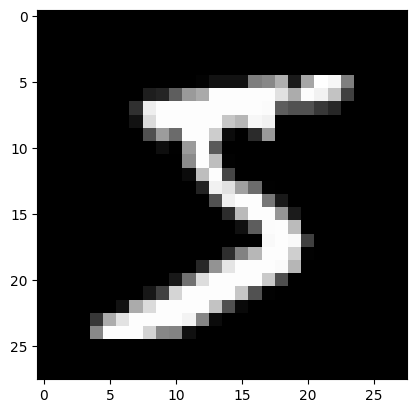

In [2]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1, 784).astype(float) / 255
y_train = train_data[1]
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [3]:
# source: https://keras.io/guides/training_with_built_in_methods/

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)


# def loss(true, pred):
#    val = 0.
#    for i in range(len(true)):
#        val -= np.log(pred[i, true[i]])
#    return val / len(true)


model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
# untrained model
logits = model(x_train)
np.argmax(logits, 1)[0:100]

array([2, 0, 0, 4, 0, 0, 5, 0, 5, 5, 5, 8, 5, 3, 5, 5, 1, 3, 1, 3, 0, 5,
       4, 4, 0, 8, 5, 5, 8, 3, 5, 0, 2, 2, 6, 5, 5, 0, 1, 5, 4, 8, 0, 4,
       2, 8, 7, 8, 5, 5, 7, 0, 5, 2, 5, 3, 0, 5, 0, 4, 5, 5, 7, 5, 7, 7,
       5, 4, 1, 5, 8, 2, 4, 3, 5, 5, 1, 4, 4, 3, 8, 5, 1, 3, 9, 5, 5, 5,
       8, 5, 0, 5, 0, 0, 2, 8, 8, 3, 4, 4])

In [5]:
# what we would like to get
y_train[0:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

In [6]:
# Computing a stochastic gradient

# Source: https://keras.io/guides/writing_a_training_loop_from_scratch/

# Example of gradient computation using automatic differentiation

x_train_batch = x_train[:8]
y_train_batch = y_train[:8]
with tf.GradientTape() as tape:
    # Run the forward pass of the layer.
    # The operations that the layer applies
    # to its inputs are going to be recorded
    # on the GradientTape.
    logits = model(x_train_batch)  # Logits for this minibatch

    # Compute the loss value for this minibatch.
    loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

# Updating weights


def update_weights(model, update):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + update[i]
    model.set_weights(new_weights)


# Evaluate model
samples_for_evaluation = np.random.randint(0, 10000, 1000)
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()

2.3274875

# Question 4.1
We can calculate the number of parameters layer by layer:
- We have 784 input neurons and 784 output neurons in the input layer and we have 784 input neurons and 32 output neurons in the first layer $b0$. So, the vector $\omega_0$ has $784*32$ parameters and the vector $b_0$ has $32$ parameters. The number of parameters is 784*32 + 32 = 25120
- We have 32 input neurons and 32 output neurons in the second layer $b1$. So the vector $\omega_1$ has $32*32$ parameters and the vector $b_1$ has $32$ parameters. The number of parameters is 32*32 + 32 = 1056
- We have 32 input neurons and 10 output neurons in the last layer $b_2$. So the vector $\omega_2$ has $32*10$ parameters and the vector $b_2$ has $10$ parameters. The number of parameters is 32*10 + 10 = 330

The total number of parameters is 25120 + 1056 + 330 = 26506

# Question 5.1

In [7]:
def train_model(model, x_train, y_train, loss_fn, epochs, batch_size, learning_rate_init):
    global_step = 0
    loss_values = []
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch+1}/{epochs}")

        indices = np.arange(len(x_train))
        np.random.shuffle(indices)
        x_train_shuffled = x_train[indices]
        y_train_shuffled = y_train[indices]

        for i in range(0, len(x_train), batch_size):
            x_train_batch = x_train_shuffled[i:i+batch_size]
            y_train_batch = y_train_shuffled[i:i+batch_size]

            learning_rate_iter = learning_rate_init / np.sqrt(global_step + 1)

            with tf.GradientTape() as tape:
                logits = model(x_train_batch, training=True)
                loss_value = loss_fn(y_train_batch, logits)

            grads = tape.gradient(loss_value, model.trainable_variables)

            global_step += 1

            if global_step % 1000 == 0:
                loss_value_all_samples = loss_fn(y_train, model(x_train, training=False))
                loss_values.append(loss_value_all_samples)
                print(f"Iteration {global_step}, Loss: {loss_value:.4f}")

            updates = [-learning_rate_iter * grad for grad in grads]
            update_weights(model, updates)

        plt.plot(loss_values)
        plt.title("Training loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()

# Question 5.2

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1
Iteration 1000, Loss: 0.8631
Iteration 2000, Loss: 0.7166
Iteration 3000, Loss: 0.1583
Iteration 4000, Loss: 0.6631
Iteration 5000, Loss: 0.2467
Iteration 6000, Loss: 0.2381
Iteration 7000, Loss: 0.4159


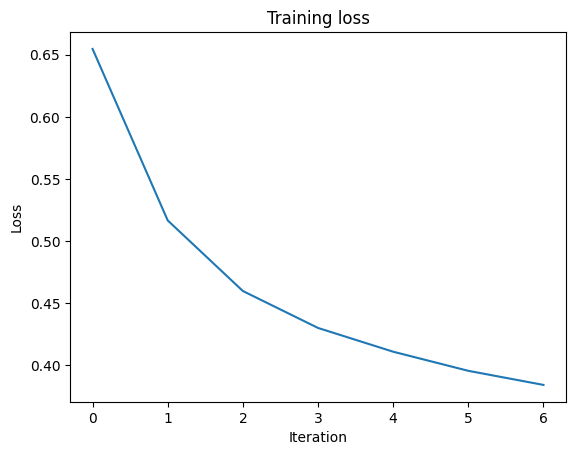

100%|██████████| 1/1 [00:22<00:00, 22.32s/it]


In [8]:
initial_learning_rate = 0.1
epochs = 1
batch_size = 8
train_model(model, x_train, y_train, loss, epochs, batch_size, initial_learning_rate)

# Question 6.1

In [9]:
def sgd_train_model(model, x_train, y_train, loss_fn, epochs, learning_rate):
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        with tf.GradientTape() as tape:
            logits = model(x_train, training=True)
            loss_value = loss_fn(y_train, logits)

        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [10]:
epochs = 10
learning_rate = 0.1
model_sgd = keras.Model(inputs=inputs, outputs=outputs)


sgd_train_model(model_sgd, x_train, y_train, loss, epochs, learning_rate)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


# Question 6.2
The advantages of such a scheme are:
- **learning statibility**: using a batch reduces noise in gradient estimation compared to using a single sample (pure SGD), while retaining some beneficial variability compared to batch gradient descent
- **faster convergence**: on average, mini-batches provide a reliable estimate of the direction in which to optimize, often enabling faster convergence

# Question 6.3

In [11]:
def sgd_batch_train_model(model, x_train, y_train, loss_fn, epochs, batch_size, learning_rate):
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            with tf.GradientTape() as tape:
                logits = model(x_batch, training=True)
                loss_value = loss_fn(y_batch, logits)

            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [12]:
epochs = 10
batch_size = 64
learning_rate = 0.1
model_sgd_batch = keras.Model(inputs=inputs, outputs=outputs)

sgd_batch_train_model(model_sgd_batch, x_train, y_train, loss, epochs, batch_size, learning_rate)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


# Question 7.1

In [13]:
x_test = test_data[0].reshape(-1, 784).astype(float) / 255
y_test = test_data[1]

model_sgd_batch.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

train_loss, train_accuracy = model_sgd_batch.evaluate(x_train, y_train, verbose=0)
print(f"Accuracy on training set: {train_accuracy * 100}%")

test_loss, test_accuracy = model_sgd_batch.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy on test set: {test_accuracy * 100}%")

Accuracy on training set: 97.8933334350586%
Accuracy on test set: 96.85999751091003%
